<div class="alert alert-primary alert-info">
    
# 赤ちゃんの portfolio adjustment の事

</div>

<div class="alert alert-danger" role="alert">

- ### Eigen weighting

- ### Hierarchical Risk Parity
    
</div>

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as dr
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(1)

In [3]:
import warnings
warnings.filterwarnings('ignore')

### DJIA Components

In [4]:
djia_components = ['MMM','AXP','AMGN','AAPL','BA','CAT','CVX','CSCO','KO','DOW','GS','HD','HON','IBM','INTC','JNJ','JPM','MCD','MRK','MSFT','NKE','PG','CRM','TRV','UNH','VZ','V','WBA','WMT','DIS']

start_date = datetime(year=2018, month=1, day=1)
end_date = datetime(year=2021, month=2, day=1)

In [5]:
djia_components_list = []

try:
    for ticker in djia_components:
        closes = dr.DataReader(ticker, 'yahoo', start_date, end_date)['Adj Close']
        closes.name = ticker
        djia_components_list.append(closes)
    djia_components_adjcloses = pd.concat(djia_components_list, axis=1)
    djia_components_adjcloses.to_csv('DJIA_Components_AdjCloses.csv')
except:
    print('Exception retrieving adjusted closes for', ticker)

### DJIA Actual

In [6]:
try:
    djia_adjcloses = dr.DataReader('DJIA','yahoo', start_date, end_date)['Adj Close']
    djia_adjcloses.to_csv('DJIA_AdjCloses.csv')
except:
    print('Exception retrieving adjusted closes for DJIA')

---

In [7]:
djia_components_adjcloses = pd.read_csv('DJIA_Components_AdjCloses.csv',index_col=0)
djia_adjcloses = pd.read_csv('DJIA_AdjCloses.csv',index_col=0)

print('-'*70)
print('DJIA components start date: ', djia_components_adjcloses.index[0])
print('DJIA start date: ', djia_adjcloses.index[0])
print('DJIA components end date: ', djia_components_adjcloses.index[-1])
print('DJIA end date: ', djia_adjcloses.index[-1])
print('DJIA components dimension: ', djia_components_adjcloses.shape)
print('DJIA dimension: ', djia_adjcloses.shape)
print('-'*70)

----------------------------------------------------------------------
DJIA components start date:  2018-01-02
DJIA start date:  2018-01-02
DJIA components end date:  2021-02-01
DJIA end date:  2021-02-01
DJIA components dimension:  (776, 30)
DJIA dimension:  (776, 1)
----------------------------------------------------------------------


---

### Preparation $\dots$

In [8]:
nan_threshold = 0.3

djia_components_mean_num_nans = djia_components_adjcloses.isnull().mean()
djia_components_tickers_to_drop = djia_components_mean_num_nans[djia_components_mean_num_nans > nan_threshold]

print('-'*70)
print('Removing DJIA component tickers with more than 30% NaNs in closing prices:\n')
print(djia_components_tickers_to_drop)

print('\nDJIA components original dimension: ', djia_components_adjcloses.shape)
djia_components_adjcloses.drop(djia_components_tickers_to_drop.index, axis=1, inplace=True)
print('DJIA components updated dimension: ', djia_components_adjcloses.shape)
print('-'*70)

djia_components_adjcloses.fillna(method='ffill', inplace=True)
djia_adjcloses.fillna(method='ffill', inplace=True)

----------------------------------------------------------------------
Removing DJIA component tickers with more than 30% NaNs in closing prices:

DOW    0.391753
dtype: float64

DJIA components original dimension:  (776, 30)
DJIA components updated dimension:  (776, 29)
----------------------------------------------------------------------


---

In [9]:
djia_components_adjcloses.head()

,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,GS,...,NKE,PG,CRM,TRV,UNH,VZ,V,WBA,WMT,DIS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,212.346481,94.095047,161.185806,41.380238,282.886383,144.235184,111.714676,35.173683,41.253933,241.290482,...,61.536419,82.617447,104.410004,122.680244,211.113892,46.476780,112.161224,67.955437,92.842651,108.726067
2018-01-03,212.337463,94.675171,164.227417,41.373032,283.801239,144.455612,112.529007,35.454273,41.163342,239.044327,...,61.526726,82.517197,105.290001,123.070663,213.328491,45.521732,113.277832,68.463173,93.652519,109.192856
2018-01-04,215.113022,96.249908,163.535339,41.565216,282.724396,146.439484,112.178757,35.554581,41.743107,242.385223,...,61.487953,83.100464,106.680000,123.070663,214.254440,45.669331,113.699020,64.918068,93.737274,109.144241
2018-01-05,216.789154,96.469421,164.509689,42.038452,294.322296,148.754028,111.994865,36.046997,41.734043,241.148911,...,62.011341,83.155174,108.099998,122.847580,218.339996,45.565140,116.422012,66.114876,94.292885,108.551003
2018-01-08,216.086212,95.581841,164.464203,41.882305,295.570740,152.492157,112.546539,36.420876,41.670639,237.647583,...,62.563805,83.592636,108.860001,122.187592,214.550339,45.487003,116.892151,66.958084,95.686600,106.994995


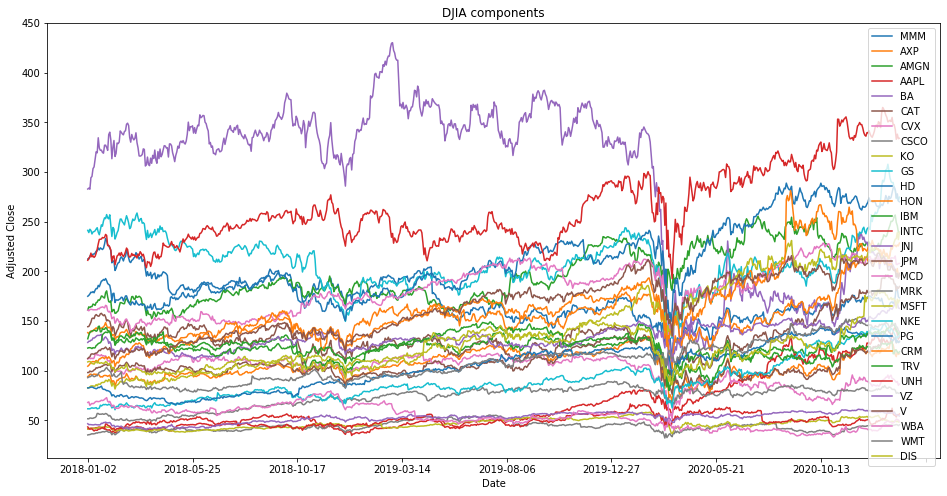

In [10]:
ax = djia_components_adjcloses.plot(figsize=(16, 8))
plt.title('DJIA components')
ax.set_ylabel('Adjusted Close');

In [11]:
djia_adjcloses.columns = ['DJIA AdjClose']
djia_adjcloses.head()

,DJIA AdjClose
Date,
2018-01-02,24824.009766
2018-01-03,24922.679688
2018-01-04,25075.130859
2018-01-05,25295.869141
2018-01-08,25283.000000


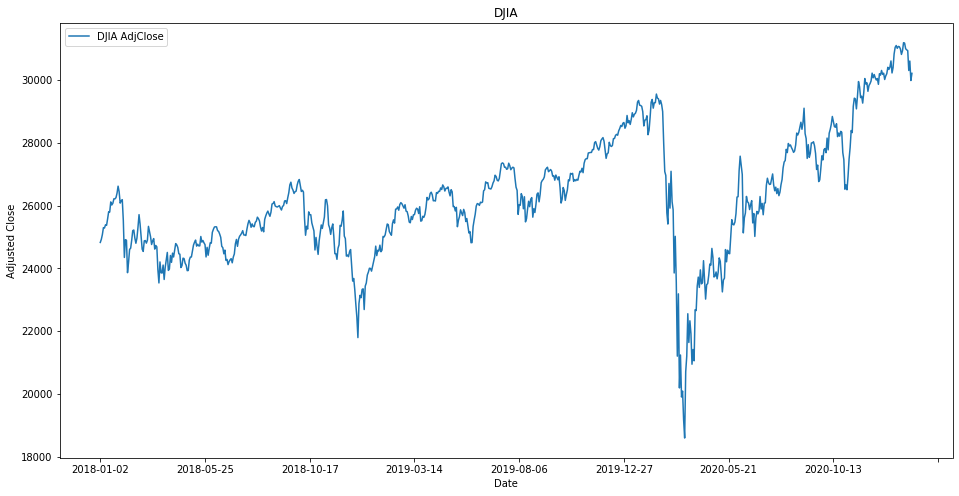

In [12]:
ax = djia_adjcloses.plot(figsize=(16, 8))
plt.title('DJIA')
ax.set_ylabel('Adjusted Close');

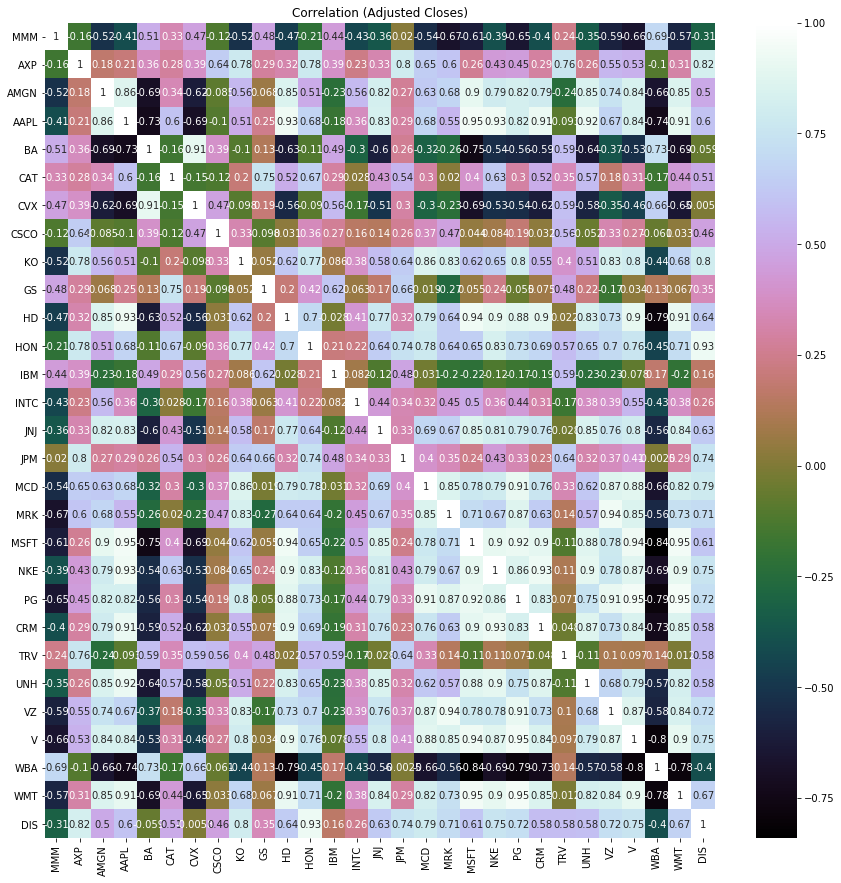

In [13]:
plt.figure(figsize=(15,15))
plt.title('Correlation (Adjusted Closes)')
sns.heatmap(djia_components_adjcloses.corr(), annot=True, cmap='cubehelix');

---

In [14]:
djia_components_returns = djia_components_adjcloses.pct_change()
djia_components_returns.drop(djia_components_returns.index[0], axis=0, inplace=True)

djia_adjcloses_returns = djia_adjcloses.pct_change()
djia_adjcloses_returns.drop(djia_adjcloses_returns.index[0], axis=0, inplace=True)

assert djia_components_returns.isnull().values.any() == False
assert djia_adjcloses_returns.isnull().values.any() == False

djia_components_returns.head()

,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,GS,...,NKE,PG,CRM,TRV,UNH,VZ,V,WBA,WMT,DIS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03,-0.000042,0.006165,0.018870,-0.000174,0.003234,0.001528,0.007289,0.007977,-0.002196,-0.009309,...,-0.000158,-0.001213,0.008428,0.003182,0.010490,-0.020549,0.009955,0.007472,0.008723,0.004293
2018-01-04,0.013071,0.016633,-0.004214,0.004645,-0.003794,0.013733,-0.003113,0.002829,0.014085,0.013976,...,-0.000630,0.007068,0.013202,0.000000,0.004340,0.003242,0.003718,-0.051781,0.000905,-0.000445
2018-01-05,0.007792,0.002281,0.005958,0.011385,0.041022,0.015805,-0.001639,0.013850,-0.000217,-0.005101,...,0.008512,0.000658,0.013311,-0.001813,0.019069,-0.002281,0.023949,0.018436,0.005927,-0.005435
2018-01-08,-0.003243,-0.009201,-0.000276,-0.003714,0.004242,0.025130,0.004926,0.010372,-0.001519,-0.014519,...,0.008909,0.005261,0.007031,-0.005372,-0.017357,-0.001715,0.004038,0.012754,0.014781,-0.014334
2018-01-09,0.006214,0.003694,0.015393,-0.000115,0.026697,0.002409,-0.005369,-0.006259,0.005000,0.008459,...,-0.007126,-0.007305,0.002664,0.007760,0.004983,-0.003668,-0.001927,-0.005823,-0.012007,-0.000727


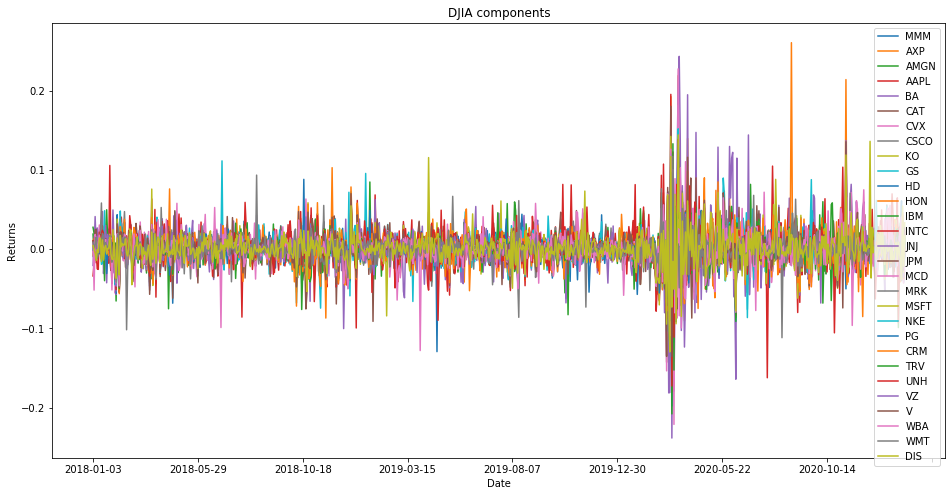

In [15]:
ax = djia_components_returns.plot(figsize=(16, 8))
plt.title('DJIA components')
ax.set_ylabel('Returns');

In [16]:
djia_adjcloses_returns.head()

,DJIA AdjClose
Date,
2018-01-03,0.003975
2018-01-04,0.006117
2018-01-05,0.008803
2018-01-08,-0.000509
2018-01-09,0.004066


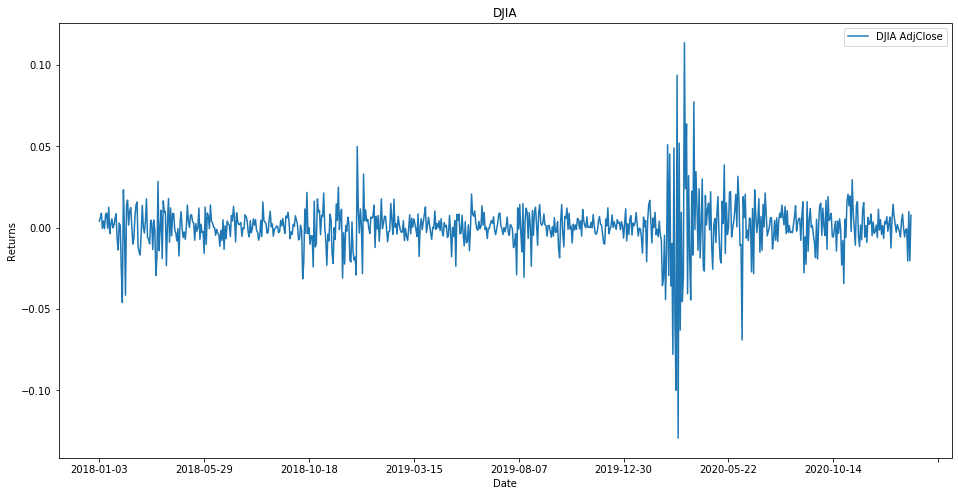

In [17]:
ax = djia_adjcloses_returns.plot(figsize=(16, 8))
plt.title('DJIA')
ax.set_ylabel('Returns');

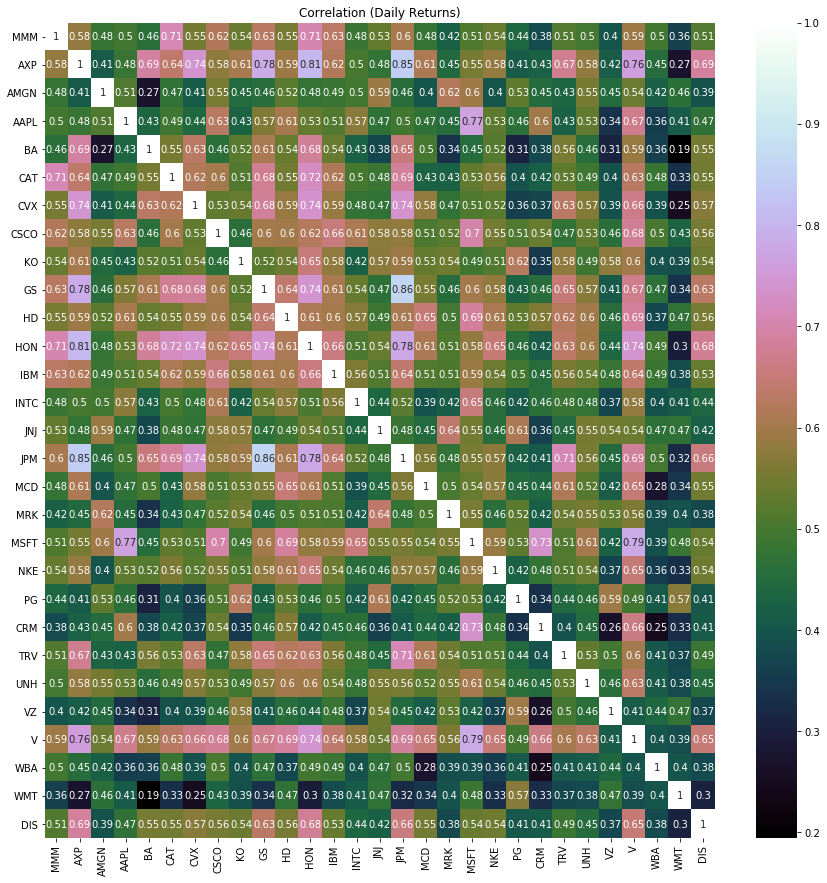

In [18]:
plt.figure(figsize=(15,15))
plt.title('Correlation (Daily Returns)')
sns.heatmap(djia_components_returns.corr(), annot=True, cmap='cubehelix');

---

## Eigen weights

---

In [19]:
rescaled_djia_components_returns = pd.DataFrame(StandardScaler().fit_transform(djia_components_returns), 
                                                columns = djia_components_returns.columns,
                                                index = djia_components_returns.index)

assert rescaled_djia_components_returns.isnull().values.any() == False

---

In [20]:
rescaled_djia_components_returns_train, rescaled_djia_components_returns_test = train_test_split(rescaled_djia_components_returns, test_size=0.2, shuffle=False)
actual_djia_components_returns_train, actual_djia_components_returns_test = train_test_split(djia_components_returns, test_size=0.2, shuffle=False)
actual_djia_adjcloses_returns_train, actual_djia_adjcloses_returns_test = train_test_split(djia_adjcloses_returns, test_size=0.2, shuffle=False)


print('-'*70)
print('Sizeof rescaled_djia_components_returns_train: ', len(rescaled_djia_components_returns_train))
print('Sizeof rescaled_djia_components_returns_test: ', len(rescaled_djia_components_returns_test))
print('Sizeof actual_djia_components_returns_train: ', len(actual_djia_components_returns_train))
print('Sizeof actual_djia_components_returns_test: ', len(actual_djia_components_returns_test))
print('Sizeof actual_djia_adjcloses_returns_train: ', len(actual_djia_adjcloses_returns_train))
print('Sizeof actual_djia_adjcloses_returns_test: ', len(actual_djia_adjcloses_returns_test))
print('-'*70)

----------------------------------------------------------------------
Sizeof rescaled_djia_components_returns_train:  620
Sizeof rescaled_djia_components_returns_test:  155
Sizeof actual_djia_components_returns_train:  620
Sizeof actual_djia_components_returns_test:  155
Sizeof actual_djia_adjcloses_returns_train:  620
Sizeof actual_djia_adjcloses_returns_test:  155
----------------------------------------------------------------------


---

In [21]:
pca = PCA().fit(rescaled_djia_components_returns_train)
pca.components_.shape

(29, 29)

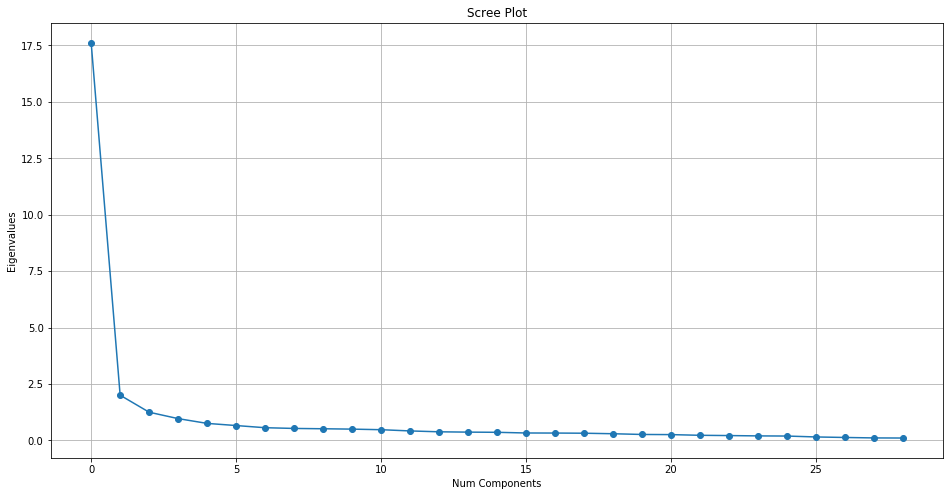

In [22]:
plt.figure(figsize = (16, 8))
plt.title('Scree Plot')
plt.xlabel('Num Components'), plt.ylabel('Eigenvalues')
plt.grid(True)
plt.plot(np.arange(len(pca.explained_variance_)), pca.explained_variance_, marker='o');

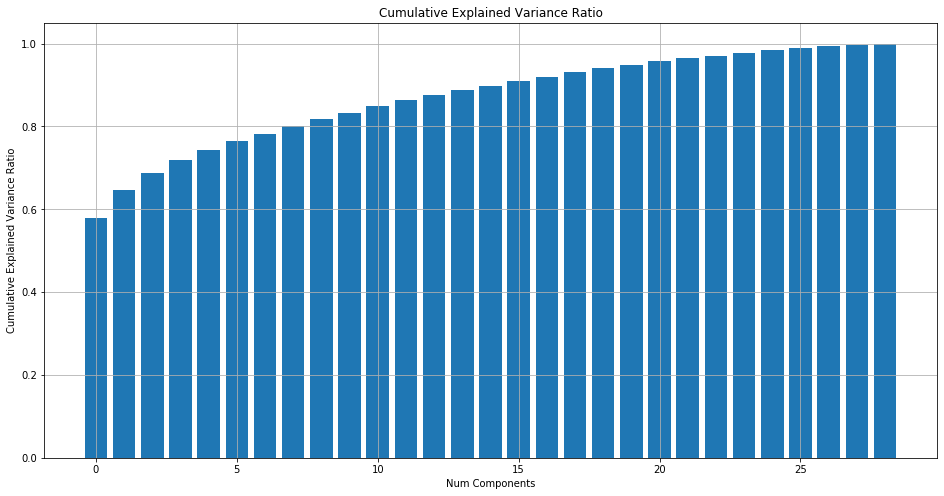

In [23]:
plt.figure(figsize = (16, 8))
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Num Components'), plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.bar(x=np.arange(len(pca.explained_variance_ratio_)), height=np.cumsum(pca.explained_variance_ratio_));

In [24]:
eigenvectors = pd.DataFrame(pca.components_, columns=djia_components_returns.columns)
eigenvectors.head()

,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,GS,...,NKE,PG,CRM,TRV,UNH,VZ,V,WBA,WMT,DIS
0,-0.190684,-0.202028,-0.170581,-0.182632,-0.166796,-0.189743,-0.187440,-0.204355,-0.179783,-0.205265,...,-0.188891,-0.171265,-0.161384,-0.187243,-0.188094,-0.155239,-0.217451,-0.141770,-0.138840,-0.178394
1,-0.029373,-0.221335,0.256314,-0.001183,-0.281680,-0.105181,-0.202281,0.063335,0.110227,-0.188719,...,-0.098878,0.347601,-0.033453,-0.055018,0.032045,0.344955,-0.106408,0.182102,0.382965,-0.139043
2,0.101553,-0.130892,0.147990,0.304800,-0.146429,0.160850,-0.153408,0.271287,-0.332889,-0.000088,...,0.020252,-0.192514,0.302345,-0.256757,-0.003678,-0.298114,0.119441,0.115438,0.042525,-0.026613
3,0.388376,0.038702,-0.040786,-0.101431,0.042252,0.353194,-0.045505,0.048678,0.071364,0.134358,...,-0.038941,0.066151,-0.312372,-0.192760,-0.152820,0.054567,-0.197698,0.390527,-0.016574,0.101865
4,-0.128889,0.043763,-0.260674,0.036670,0.106230,-0.147187,-0.163584,-0.037032,0.031009,0.091409,...,-0.031690,0.215499,0.009446,0.111906,-0.244463,0.149869,-0.041853,0.066895,0.444273,0.168295


In [25]:
eigen_weights = eigenvectors.div(eigenvectors.sum(axis=1), axis=0)
eigen_weights.index = [f'Portfolio {i}' for i in range(1, len(eigen_weights) + 1)]
eigen_weights.head()

,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,GS,...,NKE,PG,CRM,TRV,UNH,VZ,V,WBA,WMT,DIS
Portfolio 1,0.035605,0.037724,0.031852,0.034102,0.031145,0.035430,0.035000,0.038158,0.033570,0.038328,...,0.035270,0.031979,0.030134,0.034963,0.035122,0.028987,0.040604,0.026472,0.025925,0.033310
Portfolio 2,-0.085644,-0.645363,0.747351,-0.003449,-0.821313,-0.306682,-0.589805,0.184671,0.321396,-0.550262,...,-0.288305,1.013522,-0.097541,-0.160420,0.093436,1.005807,-0.310259,0.530966,1.116636,-0.405416
Portfolio 3,-2.543325,3.278098,-3.706314,-7.633508,3.667215,-4.028372,3.842005,-6.794179,8.336957,0.002213,...,-0.507205,4.821379,-7.572016,6.430286,0.092112,7.466059,-2.991309,-2.891071,-1.065012,0.666507
Portfolio 4,5.674468,0.565464,-0.595912,-1.481985,0.617340,5.160428,-0.664858,0.711217,1.042687,1.963068,...,-0.568964,0.966519,-4.563998,-2.816365,-2.232820,0.797268,-2.888512,5.705892,-0.242163,1.488326
Portfolio 5,-1.158573,0.393386,-2.343179,0.329625,0.954887,-1.323054,-1.470445,-0.332874,0.278734,0.821668,...,-0.284859,1.937104,0.084905,1.005911,-2.197457,1.347162,-0.376212,0.601315,3.993526,1.512792


---

In [26]:
assert eigen_weights.sum(axis=1).all() == 1.0

---

### Eigen portfolio weights (share Y-axis = False)

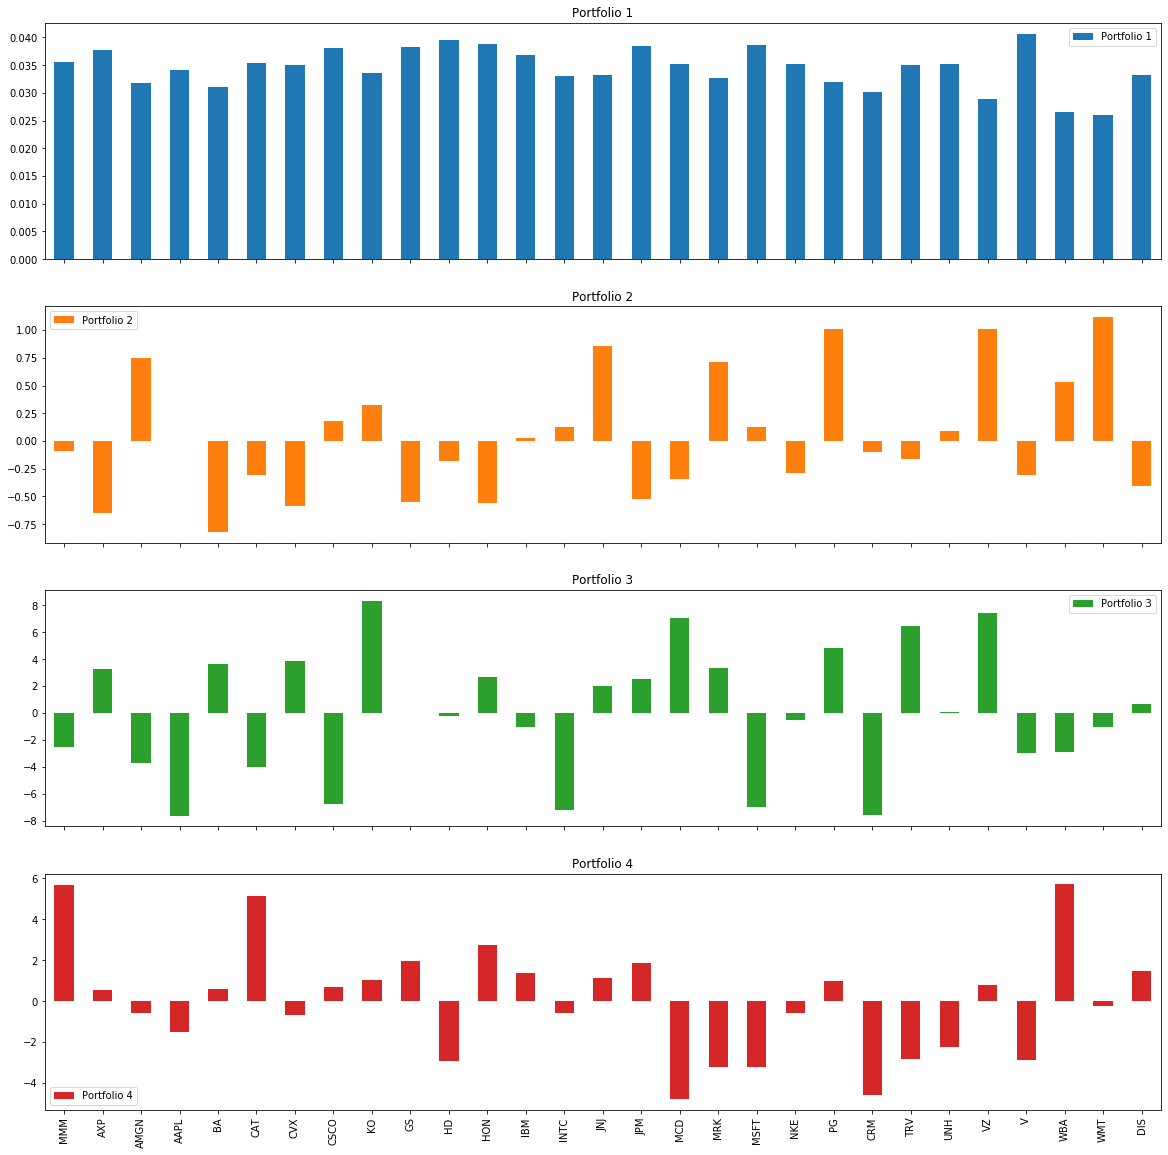

In [27]:
eigen_weights[:4].T.plot.bar(subplots=True, sharey=False, figsize=(20,20));

---

### Eigen portfolio weights (share Y-axis = True)

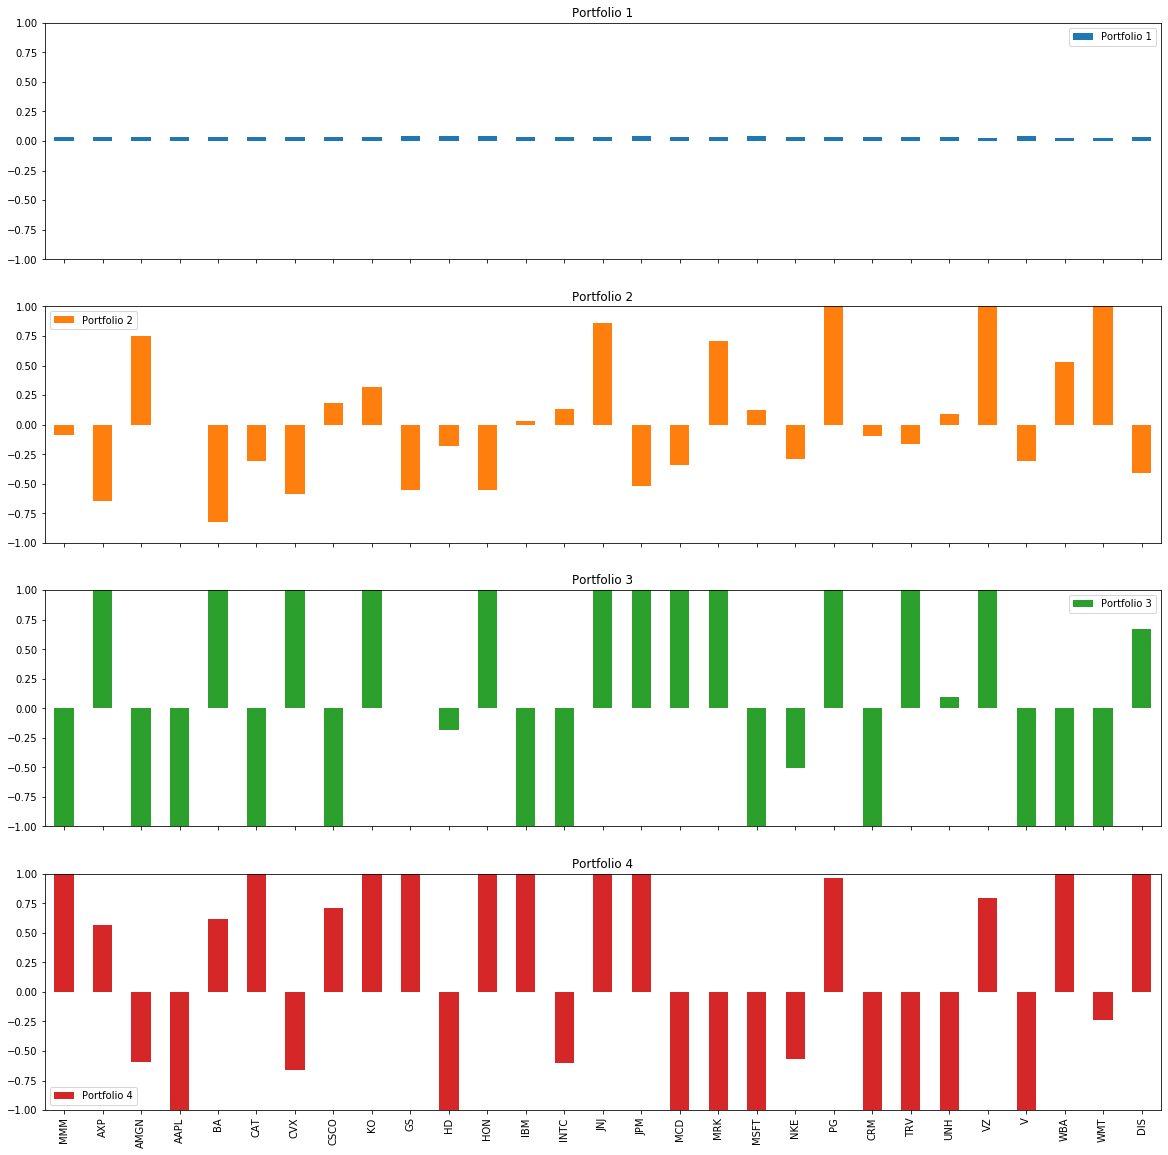

In [28]:
eigen_weights[:4].T.plot.bar(subplots=True, sharey=True, ylim= (-1,1), figsize=(20,20));

---

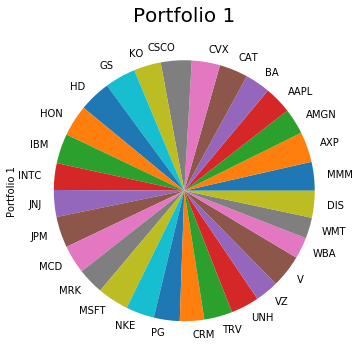

In [29]:
plt.title(eigen_weights.index[0], fontsize=20)
eigen_weights.iloc[0,:].plot.pie(figsize=(10,6));

Negative-weights (short-selling) from Portfolio 2 onwards, ...


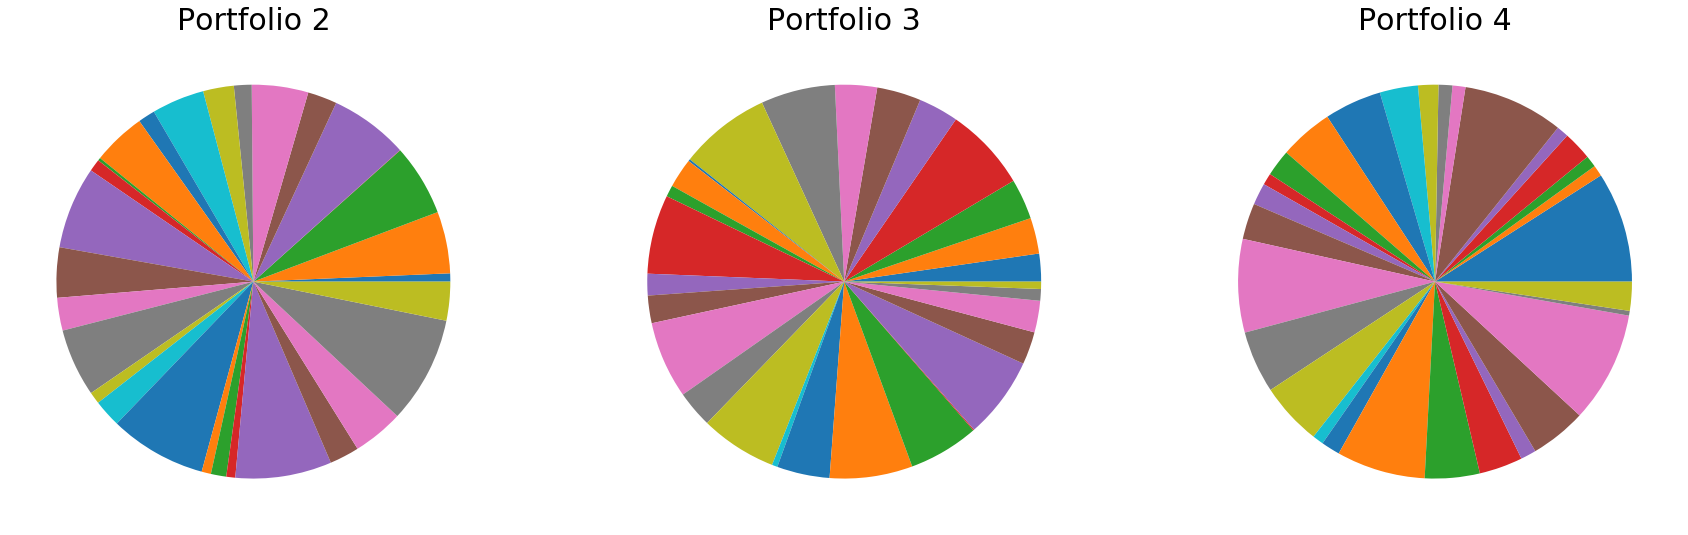

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,20))

ax1.pie(np.fabs(eigen_weights.iloc[1,:]));
ax1.set_title(eigen_weights.index[1], fontsize=30)

ax2.pie(np.fabs(eigen_weights.iloc[2,:]));
ax2.set_title(eigen_weights.index[2], fontsize=30)

ax3.pie(np.fabs(eigen_weights.iloc[3,:]));
ax3.set_title(eigen_weights.index[3], fontsize=30)

print('Negative-weights (short-selling) from Portfolio 2 onwards, ...')

---

In [31]:
def annualized_sharpe_ratio(returns, periods_per_year=252):

    # periods_per_year
    # daily scale = 252, monthly scale = 12, quarterly scale = 4

    annualized_return = (np.prod(1 + returns) ** (periods_per_year / returns.shape[0])) - 1
    annualized_vol = returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol
    return annualized_return, annualized_vol, annualized_sharpe

---

In [32]:
def portfolio_performance():

    annualized_returns = []
    annualized_vol = []
    annualized_sharpe = []

    eigen_portfolio_returns = actual_djia_components_returns_train @ eigen_weights.T

    for col in eigen_portfolio_returns:
        returns, vol, sharpe = annualized_sharpe_ratio(eigen_portfolio_returns[col])
        annualized_returns.append(returns)
        annualized_vol.append(vol)
        annualized_sharpe.append(sharpe)

    plt.figure(figsize=(20, 6))
    plt.xlabel('Portfolio')
    plt.ylabel('Annualized Sharpe')
    plt.bar(x=np.arange(1, len(eigenvectors) + 1), height=annualized_sharpe);
    
    plt.figure(figsize=(20, 6))
    plt.xlabel('Portfolio')
    plt.ylabel('Annualized Volatility')
    plt.bar(x=np.arange(1, len(eigenvectors) + 1), height=annualized_vol);
    
    plt.figure(figsize=(20, 6))
    plt.xlabel('Portfolio')
    plt.ylabel('Annualized Returns')
    plt.bar(x=np.arange(1, len(eigenvectors) + 1), height=annualized_returns);

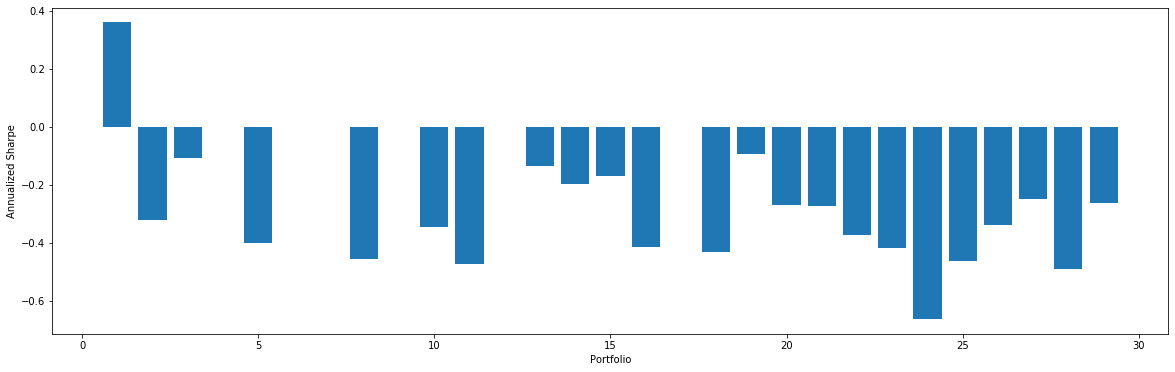

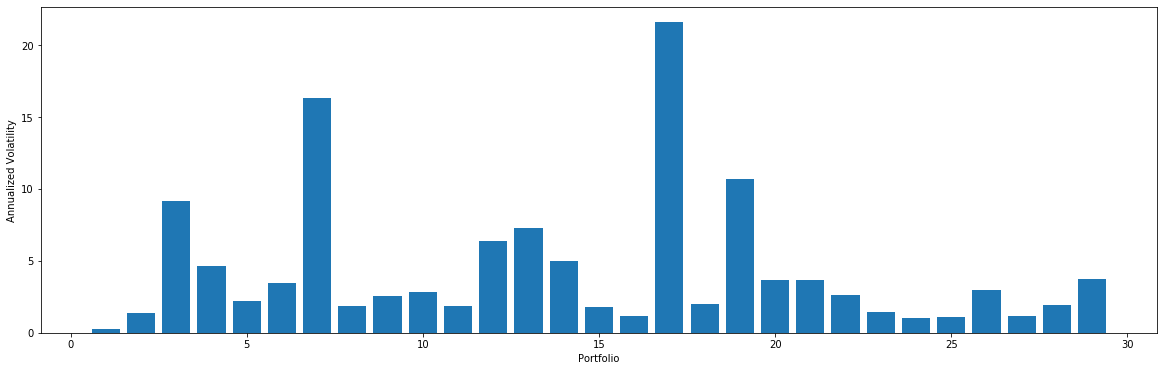

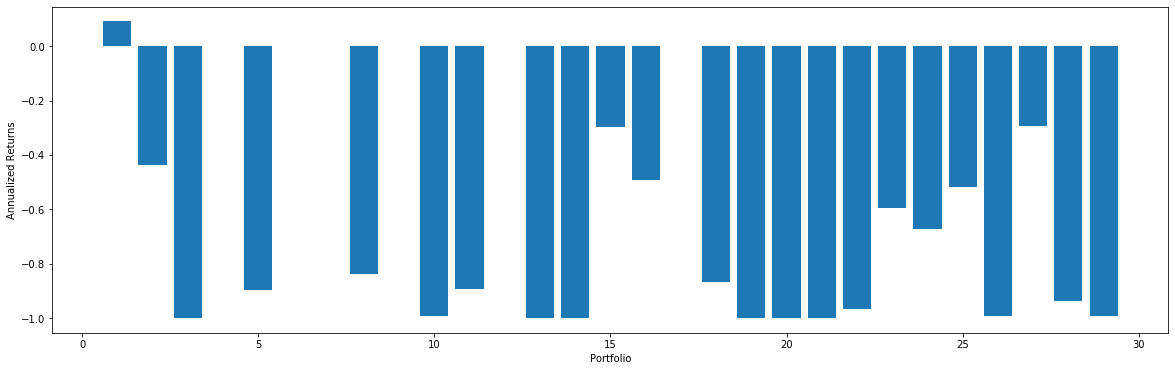

In [33]:
portfolio_performance()

---

### Backtest Eigen adjustments

#### Verify backtest data $\ldots$

In [34]:
print('-'*70)
print('DJIA components returns test data start date: ', actual_djia_components_returns_test.index[0])
print('DJIA components returns test data end date: ', actual_djia_components_returns_test.index[-1])
print('DJIA components returns test data dimension: ', actual_djia_components_returns_test.shape)

print('DJIA returns test data start date: ', actual_djia_adjcloses_returns_test.index[0])
print('DJIA returns test data end date: ', actual_djia_adjcloses_returns_test.index[-1])
print('DJIA returns test data dimension: ', actual_djia_adjcloses_returns_test.shape)
print('-'*70)

----------------------------------------------------------------------
DJIA components returns test data start date:  2020-06-22
DJIA components returns test data end date:  2021-02-01
DJIA components returns test data dimension:  (155, 29)
DJIA returns test data start date:  2020-06-22
DJIA returns test data end date:  2021-02-01
DJIA returns test data dimension:  (155, 1)
----------------------------------------------------------------------


---

In [35]:
def backtest(eigen, portfolio):
    
    eigen_returns = actual_djia_components_returns_test @ eigen.iloc[portfolio]
    returns, vol, sharpe = annualized_sharpe_ratio(pd.Series(eigen_returns))
    print('Annualized Volatility = {:.2f}%\nAnnualized Sharpe = {:.2f}%'.format(vol*100.0, sharpe))
    df_plot = pd.DataFrame({'EigenPorfolio returns': eigen_returns, 'DJIA returns': actual_djia_adjcloses_returns_test.squeeze()}, index=actual_djia_components_returns_test.index)
    ((df_plot + 1).cumprod()).plot(figsize=(20, 6), linewidth=2)
    plt.title(eigen.index[portfolio])
    plt.show()


Annualized Volatility = 17.06%
Annualized Sharpe = 1.92%


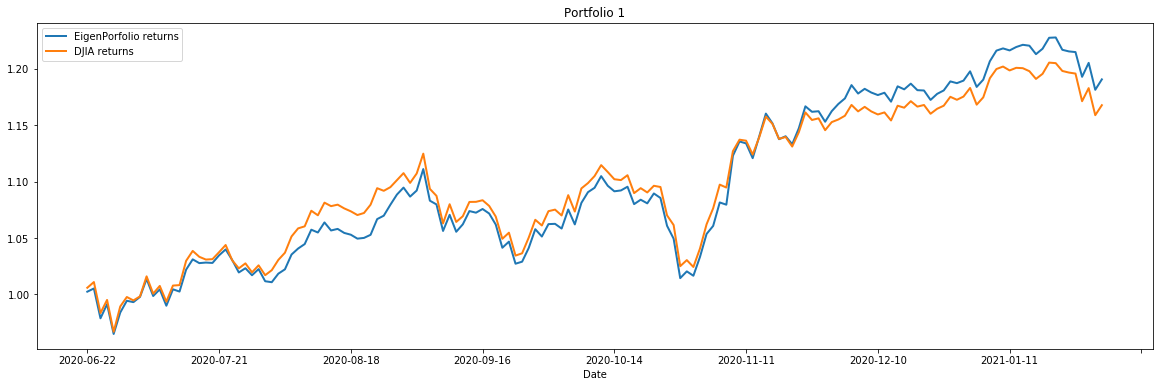

Annualized Volatility = 171.23%
Annualized Sharpe = -0.25%


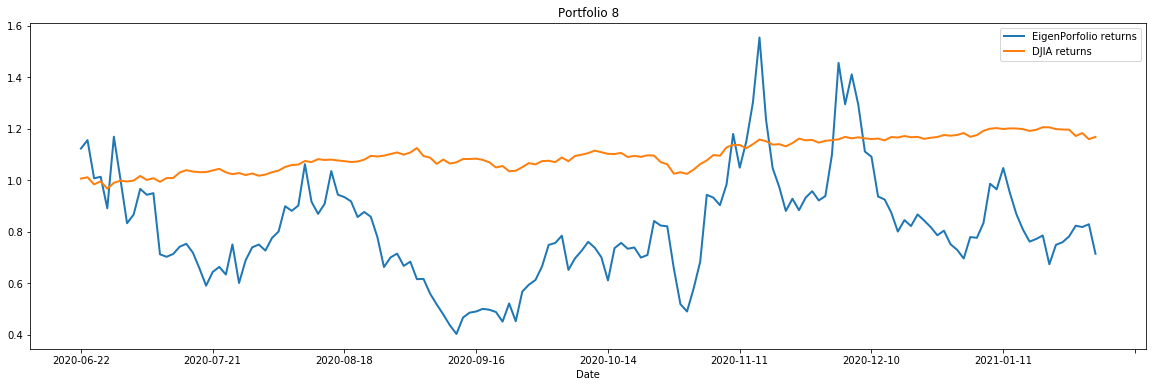

Annualized Volatility = 236.56%
Annualized Sharpe = 0.57%


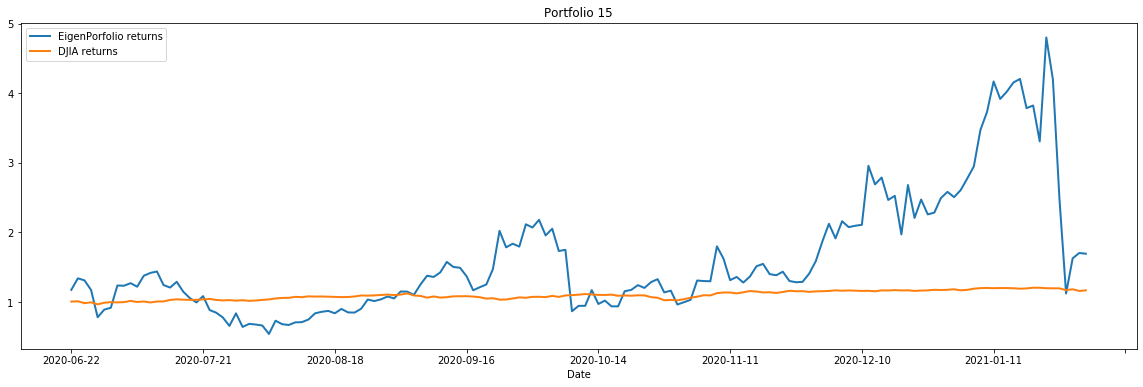

Annualized Volatility = 142.47%
Annualized Sharpe = -0.28%


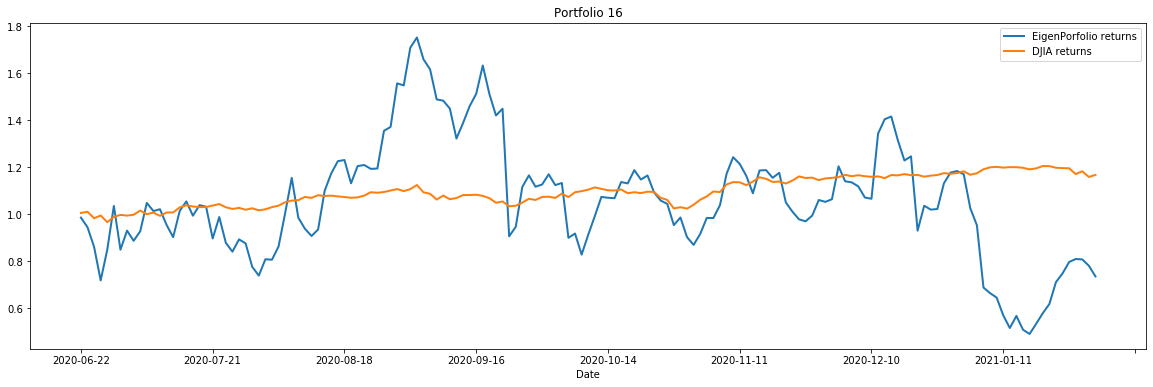

In [36]:
backtest(eigen_weights, 0)    
backtest(eigen_weights, 7)    
backtest(eigen_weights, 14)
backtest(eigen_weights, 15)

---

## Hierarchical Risk Parity

---

In [37]:
from ThirdParty.hierarchical import HRP, KnowledgeTree

from scipy.cluster.hierarchy import dendrogram, linkage

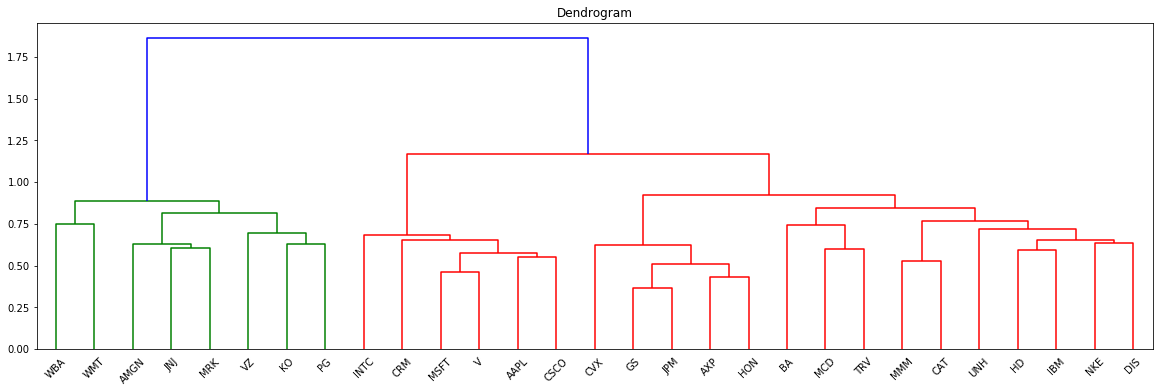

In [38]:
distance = HRP.correlDist(actual_djia_components_returns_train.corr())

plt.figure(figsize=(20, 6))
plt.title('Dendrogram')
dendrogram(linkage(distance, 'ward'), labels=actual_djia_components_returns_train.columns);

In [39]:
def hrp_eigen_portfolios(returns):
    
    hrp = HRP.getHRP(returns.cov(), returns.corr())
    hrp_eigen_portfolios = pd.DataFrame([hrp, eigen_weights.iloc[0,:]], index=['HRP', 'EigenPortfolio1'])
    return hrp_eigen_portfolios

In [40]:
hrp_eigen_portfolios = hrp_eigen_portfolios(actual_djia_components_returns_train)

In [41]:
assert hrp_eigen_portfolios.sum(axis=1).all() == 1.0

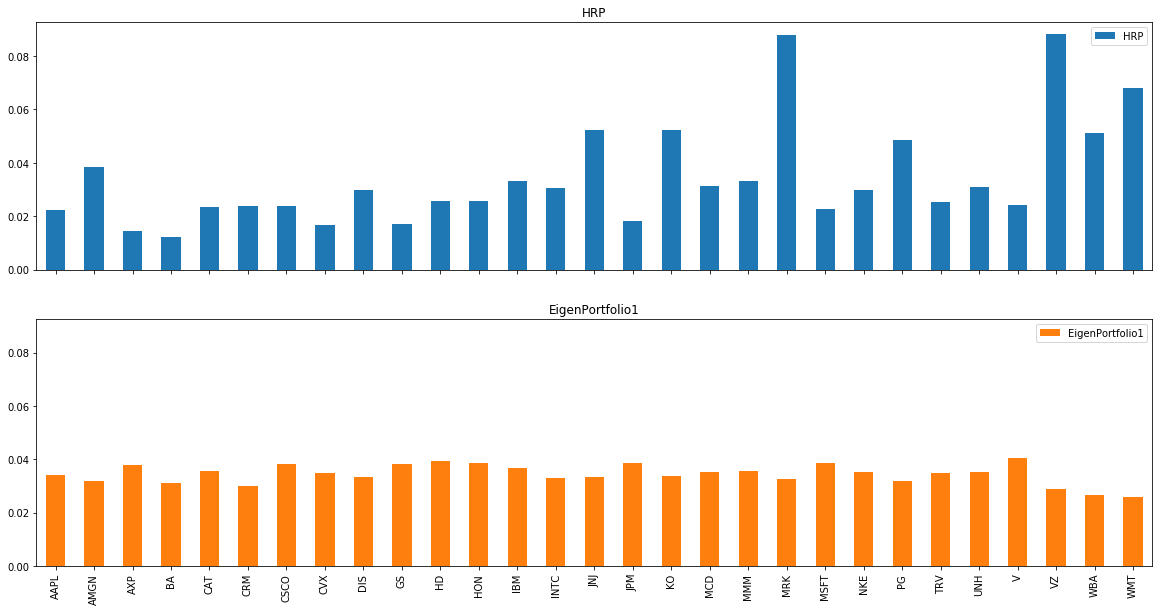

In [42]:
hrp_eigen_portfolios.T.plot.bar(subplots=True, sharey=True, figsize=(20,10));

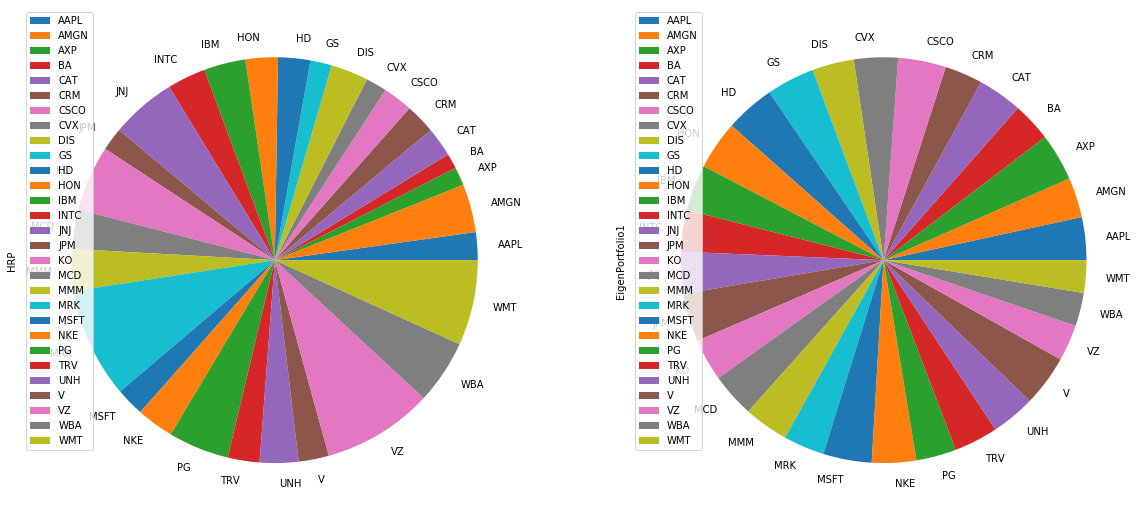

In [43]:
hrp_eigen_portfolios.T.plot.pie(subplots=True, figsize=(20, 10));

---

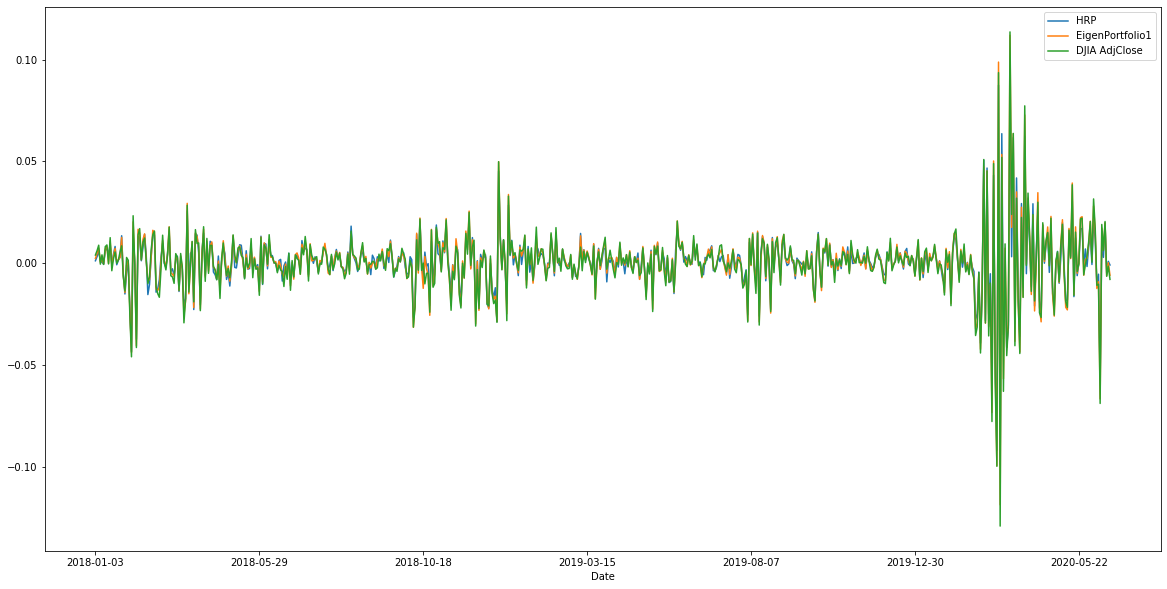

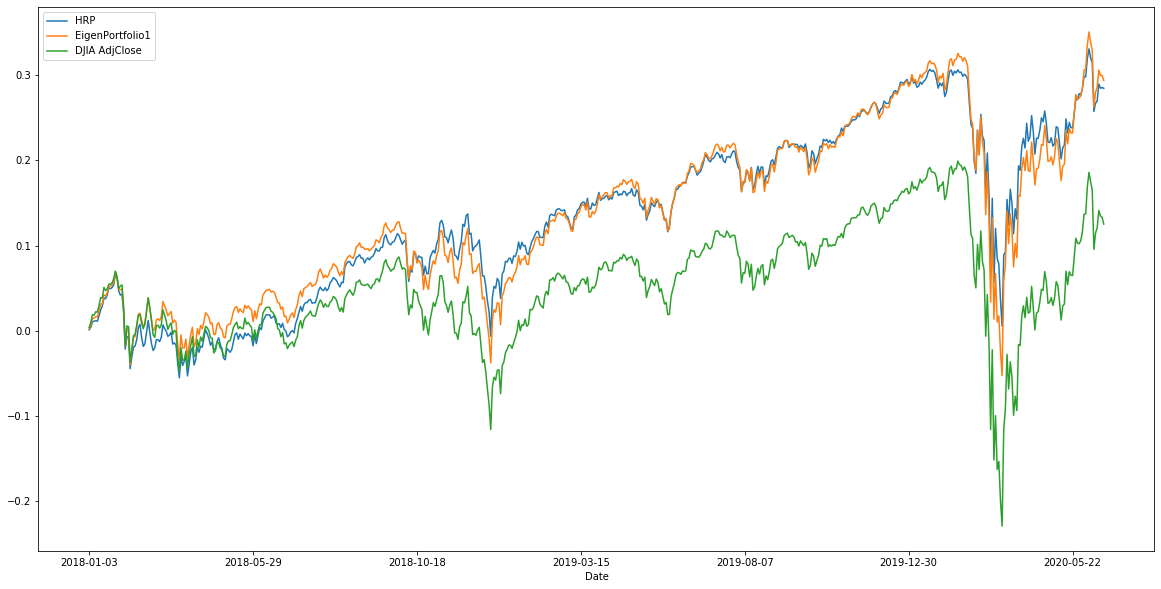

In [44]:
results = actual_djia_components_returns_train @ hrp_eigen_portfolios.T

results = pd.concat([results, actual_djia_adjcloses_returns_train], axis=1)

results.plot(figsize=(20,10));
results.cumsum().plot(figsize=(20,10));

---

### Backtest

---

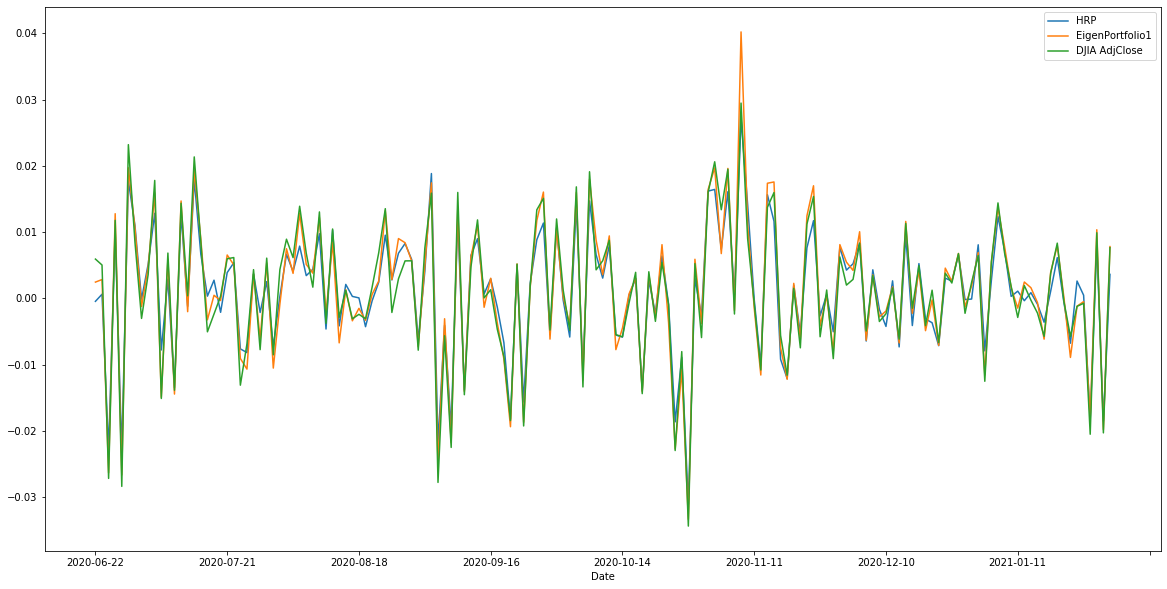

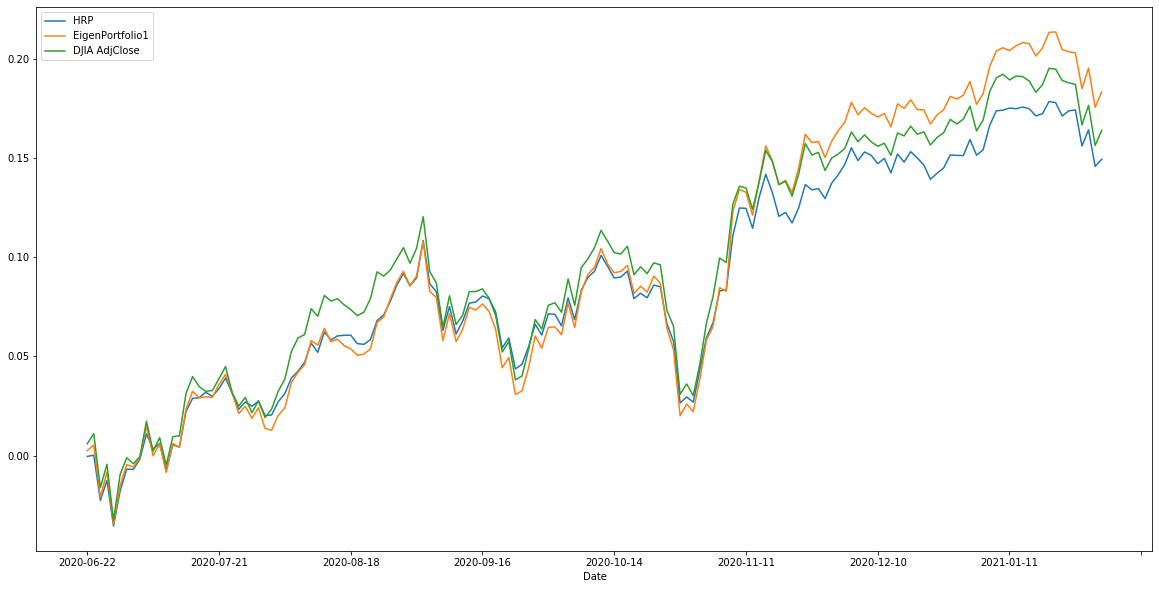

In [45]:
backtest_results = actual_djia_components_returns_test @ hrp_eigen_portfolios.T

backtest_results = pd.concat([backtest_results, actual_djia_adjcloses_returns_test], axis=1)

backtest_results.plot(figsize=(20,10));
backtest_results.cumsum().plot(figsize=(20,10));